In [1]:
import concurrent.futures

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import pyadditive.additive as pyadditive
from pyadditive.additive_machine import AdditiveMachine
from pyadditive.microstructure import MicrostructureInput

additive = pyadditive.launch_additive(ip='localhost', port=50052)

material = additive.get_material('17-4PH')
machine = AdditiveMachine.default()
machine.laser_power = 100
machine.scan_speed = 1.5
input = MicrostructureInput(machine=machine, material=material, use_provided_thermal_parameters=True)

INFO:pyadditive.additive:Connected to localhost:50052


In [2]:
summary = additive.simulate_microstructure(input)


Calculating microstructure: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


In [3]:
import pyvista as pv
from matplotlib.colors import LinearSegmentedColormap as colorMap
import ipywidgets as widgets
# pv.rcParams['use_ipyvtk'] = True

with open("xy.vtk", "wb") as xy_vtk:
    xy_vtk.write(summary.xy_vtk)
with open("xz.vtk", "wb") as xz_vtk:
    xz_vtk.write(summary.xz_vtk)
with open("yz.vtk", "wb") as yz_vtk:
    yz_vtk.write(summary.yz_vtk)
xy = pv.read("xy.vtk")
xz = pv.read("xz.vtk")
yz = pv.read("yz.vtk")

rainbow_cmap = colorMap.from_list("rainbow", ["blue", "cyan", "lime", "yellow", "orange", "red"])
white_black_cmap = colorMap.from_list("whiteblack", ['white', 'black'])

def plot_microstructure(xy_data: any, xz_data: any, yz_data: any, scalars: str, cmap: colors.LinearSegmentedColormap):
    
    font_size = 8
    plotter = pv.Plotter(shape=(2,2), notebook=True, lighting='three lights')
    plotter.show_axes_all()
    plotter.add_mesh(xy_data, cmap=cmap, scalars=scalars)
    plotter.add_title('XY Plane', font_size=font_size)
    
    plotter.subplot(0,1)
    plotter.add_mesh(xz_data, cmap=cmap, scalars=scalars)
    plotter.add_title('XZ Plane', font_size=font_size)

    plotter.subplot(1,0)
    plotter.add_mesh(yz_data, cmap=cmap, scalars=scalars)
    plotter.add_title('YZ Plane', font_size=font_size)
    
    plotter.subplot(1,1)
    plotter.add_mesh(xy_data, cmap=cmap, scalars=scalars)
    plotter.add_mesh(xz_data, cmap=cmap, scalars=scalars)
    plotter.add_mesh(yz_data, cmap=cmap, scalars=scalars)
    plotter.add_title('Combined', font_size=font_size)

    return plotter


In [4]:
p0 = plot_microstructure(xy, xz, yz, "GrainBoundaries", white_black_cmap)
p0.show()

In [5]:
p1 = plot_microstructure(xy, xz, yz, "Orientation_(deg)", 'spectral')
p1.show()

In [6]:
p2 = plot_microstructure(xy, xz, yz, "GrainNumber", None)
p2.show()

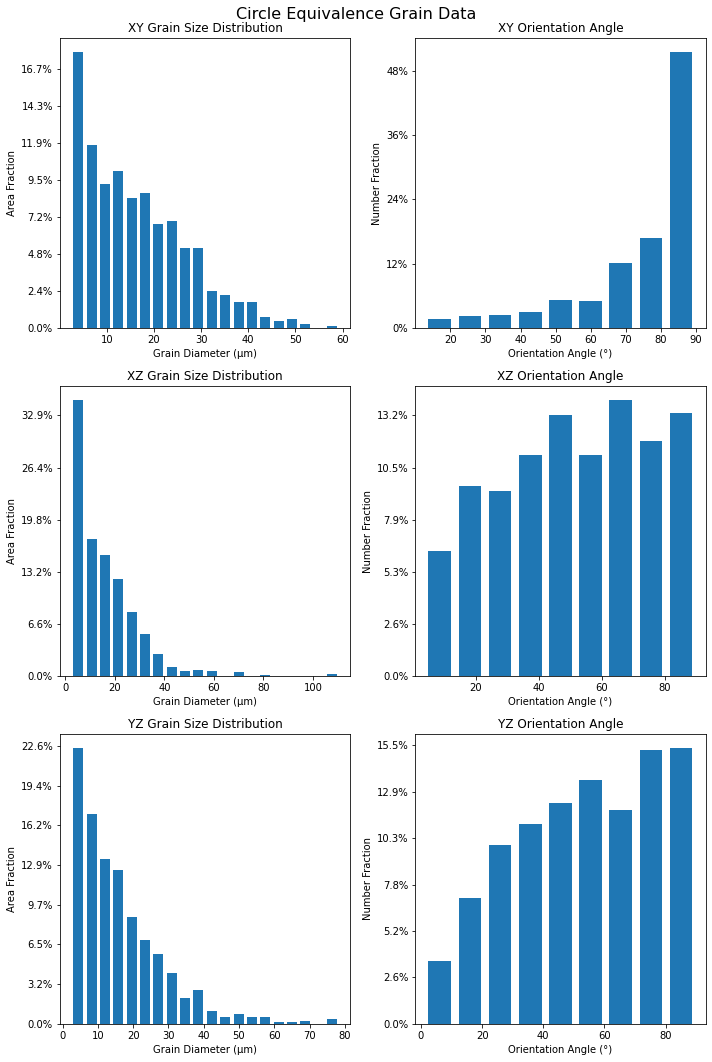

In [7]:
# area fraction vs grain size (diameter)
# number fraction vs orientation

# XY plane
def add_grain_statistics_to_figure(plane_data: dict, plane_str: str, diameter_axes: plt.Axes, orientation_axes: plt.Axes):
    xmax = len(plane_data['diameter_um'])
    diameter_axes.hist(plane_data['diameter_um'], bins=20, rwidth=0.75)
    diameter_axes.set_xlabel(f'Grain Diameter (µm)')
    diameter_axes.set_ylabel('Area Fraction')
    diameter_axes.set_title(plane_str.upper() + ' Grain Size Distribution')
    diameter_axes.yaxis.set_major_formatter(PercentFormatter(xmax=xmax))
    orientation_axes.hist(plane_data['orientation_angle'], bins=9, rwidth=0.75)
    orientation_axes.yaxis.set_major_formatter(PercentFormatter(xmax=xmax))
    orientation_axes.set_xlabel(f'Orientation Angle (°)')
    orientation_axes.set_ylabel('Number Fraction')
    orientation_axes.set_title(plane_str.upper() + ' Orientation Angle')
    
fig, axs = plt.subplots(3, 2, figsize=(10,15), tight_layout=True)
fig.suptitle('Circle Equivalence Grain Data', fontsize=16)
add_grain_statistics_to_figure(summary.xy_circle_equivalence, 'xy', axs[0][0], axs[0][1])
add_grain_statistics_to_figure(summary.xz_circle_equivalence, 'xz', axs[1][0], axs[1][1])
add_grain_statistics_to_figure(summary.yz_circle_equivalence, 'yz', axs[2][0], axs[2][1])
